<font size=20>Laboratory 7:Applications in NLP</font>


In this lab you will:
- Implement the Transformer Encoder Layer
- Understand what a language model (LM) is
- Train a Transformer LM
- Generate text from your trained Transformer model


# Part I: Transformer architecture




<img src="https://i.ibb.co/S7rqcZJ0/enc-small.png" align="left" style="margin-right: 20;" width="273" height="495"/>

#### Recap Lecture 6

The transformer encoder, introduced in ["Attention is All You Need"](https://arxiv.org/pdf/1706.03762), is designed to learn contextual representations for an input sequence $x = [x_1, ..., x_T]$. Unlike RNNs, which process each $x_i$ sequentially, a transformer layer can process the entire sequence in parallel, through the *multi-head self-attention* mechanism.

Positional information is added explicitly to the input through *positional encoding*. Attention outputs are further processed by *position-wise feed-forward netoworks*. To stabilize training and facilitate deeper architectures, each sub-layer (attention and feed-forward) is wrapped with a *residual connection* followed by *layer normalization*.

In the next sections, we'll analyze each component and work our way up to a full transformer layer implementation.


## 1. Word embeddings

### Recap intuition

<div>
<img src=https://miro.medium.com/v2/resize:fit:1400/1*sAJdxEsDjsPMioHyzlN3_A.png width="750"/>
<div>

We want to represent words in a high-dimensional space, such that words that are *semantically similar* tend to have similar features and therefore *similar vectors*.

In [ ]:
import spacy
#from spacy.lang.fr.examples import sentences
from typing import List, Tuple
import locale
import torch
import torch.nn as nn
from torch import Tensor
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 40.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
def get_tokens(sentence: str) -> Tuple[List[str], Tensor]:
    """
    Given a sentence, tokenize it (split it into words) with Spacy and
    return a list of its words.
    """
    doc = nlp(sentence)
    tokens = []
    vectors = []
    for token in doc:
        vectors.append(token.vector)
        tokens.append(token)
    word_vectors = torch.stack([torch.tensor(t) for t in vectors])

    return tokens, word_vectors

sentences = [
    "I went to the supermarket and brought groceries back home",
    "The workers went to the construction site then left early to go home",
    "The blue sky turned a reddish hue after staring at it long enough"
]

# get tokens and embeddings for one of the sentences
x = sentences[0]
x_tokens, x_embedded = get_tokens(x)
print('Tokens for sentence', x_tokens)
print('Spacy embedding dim', x_tokens[0].vector.shape)

# add batch size
x_embedded = x_embedded.unsqueeze(0)
print('x embedded shape', x_embedded.shape)

Tokens for sentence [I, went, to, the, supermarket, and, brought, groceries, back, home]
Spacy embedding dim (300,)
x embedded shape torch.Size([1, 10, 300])


## 2. Self-Attention

Recap: Self-attention identifies where the relevant features in the sequence are and extracts them, by looking at all the relationships between the tokens $(x_i, x_j)$ in a sequence $[x_1, x_2, x_3, ..., x_T]$.

Given input matrix $X \in \mathbb{R}^{B \times T \times d_{\text{model}}}$, we want to compute:
\begin{align*}
\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{Q K^\top}{\sqrt{d_k}} \right) V
\end{align*}
Where $d_{model}$ is the embedding size, T is the input sequence length, and B is the batch size.

In Laboratory 6, we implemented a simplified self-attention mehcanism, in which the keys, queries and values were the input embeddings themselves. However, in the transformer, we compute the Q, K, and V matrices via learned linear projections over the input:

\begin{align*}
Q = X W_Q, \quad K = X W_K, \quad V = X W_V
\end{align*}

Where $Q, K \in \mathbb{R}^{B \times T \times d_k}$ and $V \in \mathbb{R}^{B \times T \times d_v}$. We'll use $d_{model} = d_k = d_v$, as in the original transformer.

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, d_model, dropout=0.1):
    super().__init__()
    # embedding dim
    self.d_model = d_model
    # linear projections
    self.q_proj = nn.Linear(d_model, d_model)
    self.k_proj = nn.Linear(d_model, d_model)
    self.v_proj = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

    self.out_dropout = nn.Dropout(dropout)
    self.score_dropout = nn.Dropout(dropout)
  def forward(self, x):
    """
    :param x: input of size batch_size x seq_len x d_model
    :returns: output z of size batch_size x seq_len x d_model
              attn_scores of size batch_size x seq_len x seq_len
    """
    #TODO: compute queries, values and keys
    q = self.q_proj(x)
    k = self.k_proj(x)
    v = self.v_proj(x)

    # compute attention scores
    attn_scores = q @ k.transpose(-2, -1)
    attn_scores = attn_scores / (self.d_model ** 0.5)
    # normalize attention scores
    attn_scores = self.softmax(attn_scores)

    attn_scores = self.score_dropout(attn_scores)

    # compute attention output
    output = attn_scores @ v
    output = self.out_dropout(output)
    return output, attn_scores

Great! Let's forward through our Self-Attention module:

In [ ]:
D_MODEL = 300 # dim of the spacy embeddings
self_attn =  SelfAttention(d_model=D_MODEL).eval()
output, attn_scores = self_attn(x_embedded)
print(output.shape)

torch.Size([1, 10, 300])


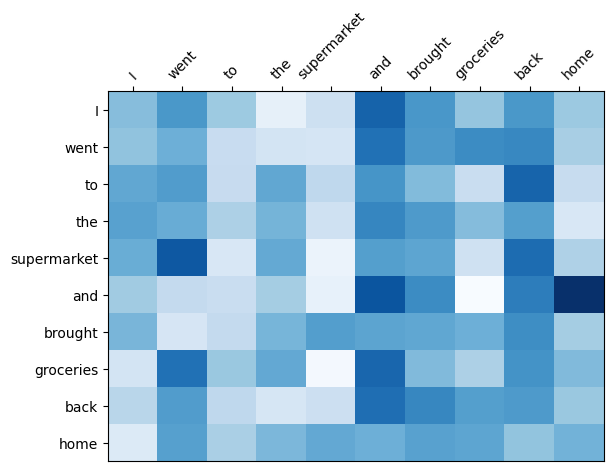

In [ ]:
# function to plot attention scores
import matplotlib.pyplot as plt
import numpy as np
def plot_scores(scores, tokens):
  fig, ax = plt.subplots()
  heatmap = ax.pcolor(scores, cmap=plt.cm.Blues)

  # put the major ticks at the middle of each cell
  ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
  ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)

  # without this I get some extra columns rows
  # http://stackoverflow.com/questions/31601351/why-does-this-matplotlib-heatmap-have-an-extra-blank-column
  ax.set_xlim(0, int(scores.shape[1]))
  ax.set_ylim(0, int(scores.shape[0]))

  # want a more natural, table-like display
  ax.invert_yaxis()
  ax.xaxis.tick_top()

  # source words -> column labels
  ax.set_xticklabels(tokens, minor=False)
  # target words -> row labels
  ax.set_yticklabels(tokens, minor=False)

  plt.xticks(rotation=45)

  # plt.tight_layout()
  plt.show()

tokens = x_tokens
plot_scores(attn_scores.detach().squeeze(), tokens)

Usually, attention plots are fairly interpretable, as we saw in Lab 6. However, the linear projections in our module are not trained yet, so noisiness is expected.

### Masked Self-Attention

In some situations, we do not want to compute full self-attention (every token attens to all other tokens) during training.

Modern LLMs are trained with the **Causal Language Modeling** objective - at every step, the model predicts the next token, given the previous ones. The model's predictions should therefore only depend on tokens to the left of the current position. We prevent attention from attending to 'the future' by masking the tokens on the right side.

The mask is added to attention scores before applying Softmax - elements above the main diagonal are masked with `-inf`.

![Attention](https://i.ibb.co/6D0sfJt/attention.png)

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, d_model, dropout=0.1):
    super().__init__()
    self.d_model = d_model
    self.q_proj = nn.Linear(d_model, d_model)
    self.k_proj = nn.Linear(d_model, d_model)
    self.v_proj = nn.Linear(d_model, d_model)
    self.softmax = nn.Softmax(dim=-1)
    self.out_dropout = nn.Dropout(dropout)
    self.score_dropout = nn.Dropout(dropout)

  # let's add an optional mask parameter to the forward pass
  def forward(self, x, mask=None):
    """
    :param x: input of size batch_size x seq_len x d_model
    :param mask: attn mask of size seq_len x seq_len
    :returns: output z of size batch_size x seq_len x d_model
              attn_scores of size batch_size x seq_len x seq_len
    """
    #TODO: compute queries, keys, and values
    q = self.q_proj(x)
    k = self.k_proj(x)
    v = self.v_proj(x)

    attn_scores = q @ k.transpose(-2, -1)
    attn_scores = attn_scores / (self.d_model ** 0.5)
    # !! the mask is added to unormalized attention scores
    if mask is not None:
      attn_scores += mask
    # normalize attention scores
    # Q: what happens to positions filled with -inf after softmax?
    attn_scores = self.softmax(attn_scores)
    attn_scores = self.score_dropout(attn_scores)

    # compute attention output
    output = attn_scores @ v
    output = self.out_dropout(output)

    return output, attn_scores

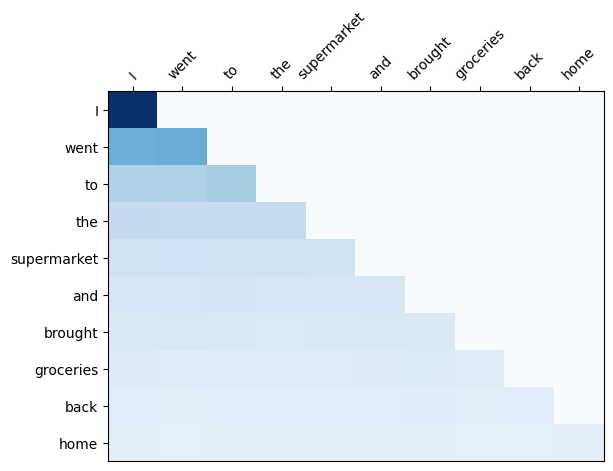

In [ ]:
max_sequence_length = x_embedded.shape[1] # T
# masked positions are filled with -inf
# unmasked positions are filled with 0
causal_mask = nn.Transformer.generate_square_subsequent_mask(max_sequence_length)
self_attn = SelfAttention(d_model=D_MODEL).eval()
# forward pass through the sequence with causal mask
output, attn_scores = self_attn(x_embedded, mask=causal_mask)
# plot again, notice any difference?
plot_scores(attn_scores.detach().squeeze(), tokens)

### Multihead Self-Attention (MHA)

We now have a full implementation of a **single-head** Self-Attention layer, with the option to mask certain input positions. This module can learn one set of relationships between the elements of sequence `x`. However, there are multiple types of dependencies between words in a sentence, so why stop here?

In MHA, for a chosen `num_heads` > 1, Self-Attention is computed `num_heads` times, in parallel. Each head has its own queries, keys, and values, and learns a different subspace. The final output becomes:

\begin{aligned}
\text{MultiHead}(Q, K, V) &= \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^O \\
\text{where} \quad \text{head}_i &= \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) \\
\end{aligned}

Where  $W^O \in \mathbb{R}^{B \times d_{model} \times d_{model}}$ is a projection matrix that learns to mix information from all heads.

In practice, the embedding dimension `d_model` is typically split into `num_heads` attention heads of size `head_dim = d_model // num_heads`.

In [ ]:
import math
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
      super().__init__()
      self.d_model = d_model
      self.num_heads = num_heads
      # compute head dimension
      self.head_dim = d_model // num_heads
      # --> d_model = head_dim * num_heads
      # so we can still use one linear transformation
      # to get q, k, v for all heads in one pass
      self.q_proj = nn.Linear(d_model, d_model)
      self.k_proj = nn.Linear(d_model, d_model)
      self.v_proj = nn.Linear(d_model, d_model)
      # output projection to combine heads
      self.o_proj = nn.Linear(d_model, d_model)
      self.softmax = nn.Softmax(dim=-1)
      self.out_dropout = nn.Dropout(dropout)
      self.score_dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
      """
      :param x: input of size batch_size x seq_len x d_model
      :param mask: attn mask of size seq_len x seq_len
      :returns: output z of size batch_size x seq_len x d_model
              attn_scores of size batch_size x num heads x seq_len x seq_len
      """
      #TODO: compute queries, keys, and values
      # q = ...
      # k = ...
      # v = ...
      q = self.q_proj(x)
      k = self.k_proj(x)
      v = self.v_proj(x)

      # split qkv into individual heads
      bs, seq_len, _ = x.size()
      # bs x seq_len x d_model --> bs x num_heads x seq_len x head_dim
      q = q.view(bs, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
      k = k.view(bs, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
      v = v.view(bs, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

      # TODO: just good old self-attention
      attn_scores = q @ k.transpose(-2, -1)
      attn_scores = attn_scores / math.sqrt(self.head_dim)
      if mask is not None:
          attn_scores += mask
      attn_scores = self.softmax(attn_scores)
      attn_scores = self.score_dropout(attn_scores)

      output = attn_scores @ v

      # combine heads
      # bs x num_heads x seq_len x head_dim  --> bs x seq_len x d_model
      output = output.transpose(1, 2).contiguous()
      output = output.view(bs, seq_len, self.head_dim*self.num_heads)

      #TODO: apply output projection(wO)
      output = self.o_proj(output)
      output = self.out_dropout(output)

      return output, attn_scores

In [ ]:
NUM_HEADS = 6
mha = MultiHeadAttention(d_model=D_MODEL, num_heads=NUM_HEADS).eval()
output, attn_scores = mha(x_embedded, mask=causal_mask)
print(output.shape)
print(attn_scores.shape)

torch.Size([1, 10, 300])
torch.Size([1, 6, 10, 10])


## 3. Wait... what about input positions?

To inject positional information about tokens in the sequence, we use [Positional Encoding](https://www.researchgate.net/figure/Positional-encoding-for-the-feature-representations-Top-Sinusoidal-representation-for_fig2_372249718). PE is added to the input embedding.

For simplicity, we'll use sinusoidal positional encoding, an absolute PE scheme, in which each dimension corresponds to a sinusoidal wavelength. These wavelengths have different frequencies, so every position gets assigned a combination of $sin$ and $cos$ values.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # embeddings + possitional embeddings
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

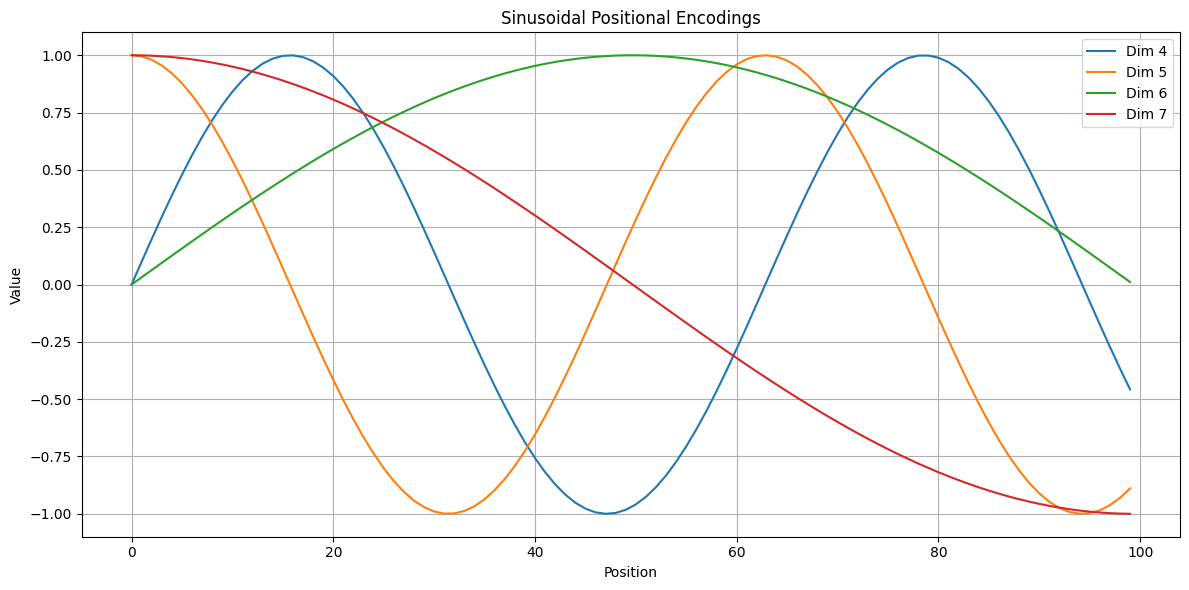

In [ ]:
# plot some waves
pe = PositionalEncoding(d_model=16, max_len=100).eval()
pos_encoding = pe.pe[0, :100, :20].detach().numpy()

plt.figure(figsize=(12, 6))
for i in [4, 5, 6, 7]:
    plt.plot(pos_encoding[:, i], label=f'Dim {i}')
plt.title("Sinusoidal Positional Encodings")
plt.xlabel("Position")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

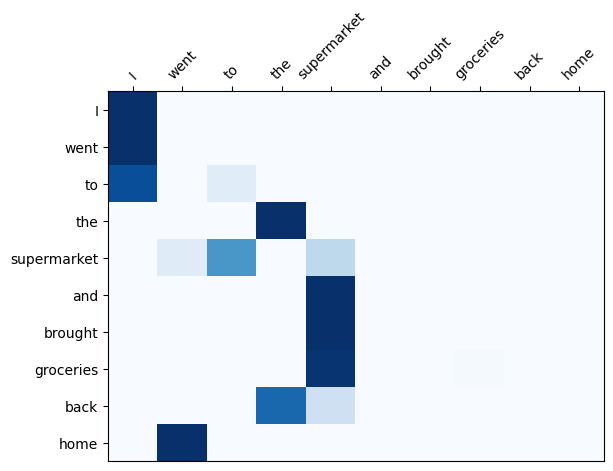

In [ ]:
pe = PositionalEncoding(d_model=D_MODEL).eval()
x = x_embedded
add_pe = True # TODO: compare attn scores with and without positional embeddings

if add_pe:
  # it's common practice to scale embeds
  # before adding pe
  x = pe(x_embedded * (D_MODEL ** 0.5))
attn_output, attn_scores = mha(x, mask=causal_mask)
head = 2 # TODO: try looking at different attn heads, do they focus on the same tokens?
scores = attn_scores[:, head, :, :].squeeze().detach()
plot_scores(scores, tokens)

## 4. Feed-Forward Network (FFN)

After the MultiHeadAttention layer (and after normalization, more on that soon) we process outputs with a Feed-Forward Network (FFN):

\begin{align*}
FFN(x) = ReLU(xW_1 + b_1)W_2 + b_2
\end{align*}

While attention mixes information from all unmasked tokens in the sequence, the FFN is applied individually to each token, which is why it's sometimes called a *position-wise* FFN.

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, d_model, d_ff=None, dropout=0.1):
    super().__init__()
    self.d_ff = d_ff if d_ff else 4 * d_model
    self.w_1 = nn.Linear(d_model, self.d_ff)
    self.w_2 = nn.Linear(self.d_ff, d_model)
    self.activation = nn.ReLU()
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    """
    :param x: input of size batch_size x seq_len x d_model
    :returns: FFN representtions, same shape as input
    """
    #TODO: pass x through the FFN (see equation above)
    x = self.w_2(self.activation(self.w_1(x)))
    x = self.dropout(x)
    return x

In [ ]:
ffn = FeedForward(d_model=D_MODEL).eval()
dummy_ffn_input = torch.zeros_like(attn_output)
output = ffn(dummy_ffn_input)
print(output.shape)

torch.Size([1, 10, 300])


## 5. Residual connections and LayerNorm

We are still missing two key ingredients to link the MHA and FFN components into a transformer layer.

*   Residual connections: help prevent vanishing gradients and preserve information across layers, applied to the output of both MHA and FFN
*   [LayerNormalization](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html): normalizes along features instead of examples

The final flow of an input $X$ through the transformer layer can be defined as:

\begin{align*}
X = LayerNorm(X + MultiHeadAttn(X)) \\
X = LayerNorm(X + FFN(X))
\end{align*}

Alternatively, LayerNorm can be applied before the residual connection (common nowadays).

In [ ]:
class TransformerLayer(nn.Module):
  def __init__(self, d_model, num_heads, d_ff=None, dropout=0.1):
    super().__init__()
    self.d_model = d_model
    self.mha = MultiHeadAttention(
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout
    )
    self.ffn = FeedForward(
        d_model=d_model,
        d_ff=d_ff,
        dropout=dropout
    )
    #layer norms
    self.norm_attn = nn.LayerNorm(d_model)
    self.norm_ffn = nn.LayerNorm(d_model)

  def forward(self, x, mask=None):
    attn_output, attn_scores = self.mha(x, mask)
    #TODO: write the residual
    x = self.norm_attn(x + attn_output)
    x = self.norm_ffn(x + self.ffn(x))
    return x, attn_scores


In [ ]:
transformer_layer = TransformerLayer(d_model=D_MODEL, num_heads=NUM_HEADS)
x, _ = transformer_layer(x_embedded)
print(x.shape)

torch.Size([1, 10, 300])


# Language model

## Definition
A language model is a system that predicts the next token, given the previous ones:
$$P(x_t|x_1,...x_{t-1})$$

If we know the intermediate probabilities $P(x_1)$, $P(x_2|x_1)$, $P(x_3|x_1, x_2)$, ..., $P(x_t|x_1,...x_{t-1})$ we can compute the joint probability of the whole sequence $x_1, x_2, ..., x_T$.
So, a language model can also be seen as a system that computes the probability of a sequence of tokens (words/characters):

$$P(x_1, x_2, x_3, ..., x_T)
=P(x_1)P(x_2|x_1)P(x_3|x_1,x_2)...P(x_T|x_1,...,x_{T-1})$$
$$=P(x_1) \prod_{t=1}^{T}P(x_t|x_1,...x_{t-1})$$

## Applications

 - **speech recognition**: which sentence is more probable?

>> $P(recognize, beach) > P(wreck, a, nice, beach)$

- **predictive typing**: what's the next most probable word?

>> $P(x_t| I, cannot, wait, to, go, to, the)$

- **transfer learning**: training a model to solve this task results in the model learning general language features which can transfer to other tasks

## Transformer LM: overview of the architecture

![decoder](https://i.ibb.co/KjTWPFwD/Screenshot-2025-04-09-at-02-46-00.png)

The network has the following main components:
 - an **embedding layer** that converts each token $x_t$ (given as an index) into a token embedding $e_t$:

      $7$ -> Embedding layer -> $[0.12, -0.16, ..., 0.43]$
       
      The token indices that we feed into the network range from 0 to $|V|-1$, where $|V|$ is the size of our vocabulary (how many unique tokens we represent).   
 - the **transformer**, made up of $K$ stacked `TransformerLayer` (implemented in Part I) layers
 - a linear **output layer** that transforms the output of the transformer into a vector of probabilities (of size $|V|$).

 At each position, the probability of the next token is maximized, so all individual tokens end up contributing to the loss. Masked self-attention ensures the model cannot cheat by attending to positions in the future.

 The unnormalized probabilities are called the *logits*. The entire architecture presented above is often refered to as a *decoder-only transformer*.

# Part II: Training a Transformer Language Model

## Step 1: Data preparation
We will use a subset of the TinyStories dataset (https://arxiv.org/pdf/2305.07759). It contains synthetic short stories, generated such that the typical 4 year-old could understand them.


In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
MAX_LENGTH = 250
BATCH_SIZE = 32

In [ ]:
from datasets import load_dataset
data = load_dataset("roneneldan/TinyStories")
train_stories = data['train']['text'][:10000]
val_stories = data['validation']['text'][:10000]
print(train_stories[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.


In [ ]:
import re
import string

def clean_text(text):
    # this dataset has the occasional weird character
    allowed_chars = string.ascii_letters + string.punctuation + ' ' + '\n'
    return ''.join(c for c in text if c in allowed_chars)

train_stories = [clean_text(story) for story in train_stories]
val_stories = [clean_text(story) for story in val_stories]

### Text representation

Let us define V = {'token0', 'token1', ..., 'token_|V|'}  as the set of all unique tokens that appear in our text. This is called the **vocabulary**.

Each token is stored as an index that ranges from 0 to |V|-1 (e.g. 'token0'->0, 'token1'->1 etc.)

The Vocabulary class below creates the **token->index** and **index->token** mappings, given a text.

In [ ]:
import re
# note: this is a toy tokenizer for our very small scale experiment
# see BPE https://huggingface.co/learn/llm-course/chapter6/5
# to understand how pretrained tokenizers are typically obtained

def tokenize(text):
    # we consider to be invididual tokens:
    # - words
    # - individual punctuation characters
    # - whitespace - new lines, spaces etc
    pattern = r'\w+|[^\w\s]|\s'
    return re.findall(pattern, text)

In [ ]:
class Vocabulary:
    """
    Helper class that maps words to unique indices and the other way around
    """
    def __init__(self, samples: List[str]):
        vocabulary = set()
        for sample in samples:
          tokens = tokenize(sample)
          vocabulary.update(tokens)

        self.token_to_idx = {token:idx for (idx, token)
                            in enumerate(vocabulary)}
        self.idx_to_token = {idx:token for (idx, token)
                            in enumerate(vocabulary)}

    def size(self):
        return len(self.token_to_idx)

    def __str__(self):
        return str(self.token_to_idx)

vocab = Vocabulary(train_stories + val_stories)
print("Vocabulary size: ", vocab.size())
print("Vocabulary: \n", vocab)

Vocabulary size:  12879
Vocabulary: 
 {'owie': 0, 'hind': 1, 'sprinkler': 2, 'Teacher': 3, 'Jimmy': 4, 'climber': 5, 'anticipation': 6, 'towels': 7, 'bloomed': 8, 'Ow': 9, 'Robby': 10, 'coughed': 11, 'across': 12, 'nasty': 13, 'whirlpool': 14, 'mental': 15, 'cafes': 16, 'bowstring': 17, 'measure': 18, 'creatures': 19, 'spreading': 20, 'cherries': 21, 'smells': 22, 'Dippy': 23, 'encircling': 24, 'damp': 25, 'occasion': 26, 'adds': 27, 'simply': 28, 'Oscar': 29, 'Ravi': 30, 'marches': 31, 'get': 32, 'reads': 33, 'sinks': 34, 'lightning': 35, 'coolers': 36, 'Whale': 37, 'unwanted': 38, 'build': 39, 'best': 40, 'sledding': 41, 'prancing': 42, 'responsibly': 43, 'Friendships': 44, 'Place': 45, 'hmm': 46, 'Agreed': 47, 'mourn': 48, 'crunches': 49, 'poem': 50, 'involving': 51, 'fog': 52, 'Monday': 53, 'living': 54, 'palace': 55, 'illuminating': 56, 'scanning': 57, 'NOT': 58, 'headband': 59, 'enlightenment': 60, 'flourished': 61, 'milk': 62, 'hurt': 63, 'Isabel': 64, 'threatened': 65, 'sunburn

**TODO**: Write the text_to_tensor and tensor_to_text functions below. Check that a text is correctly encoded and decoded back.

In [ ]:
def text_to_tensor(text: str, vocab: Vocabulary) -> torch.LongTensor:
    """
    Convert a string to a Tensor with corresponding character indices
    e.g. "We have" -> [48, 13]
    """
    #TODO
    token_ids = [vocab.token_to_idx[token] for token in tokenize(text)]
    return torch.tensor(token_ids)

def tensor_to_text(x: torch.LongTensor, vocab: Vocabulary) -> str:
    """
    Convert a Tensor of token indices to its string representation
    e.g. [48, 13] -> "We have"
    """
    #TODO
    return "".join(vocab.idx_to_token[idx.item()] for idx in x)

In [ ]:
original_text = train_stories[1]
token_ids = text_to_tensor(original_text, vocab)
decoded_text = tensor_to_text(token_ids, vocab)
assert original_text == decoded_text, "Not the same text as the original"

### The Embedding layer

We can now map each token in our dataset to an unique index, from 0 to $|V| -1$. Next, we want to represent each token as a dense vector (word embedding).
  
We can store the embeddings as rows in an embedding matrix W. The matrix W has size $|V| \times d_{model}$ ($d_{model}$ = size of the embedding).

The **Embedding** layer in PyTorch is a wrapper over W (https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding) that receives a scalar **i** and returns the **i-th** row of W.
By default, the embedding layer is initialized with random weights. These are updated during task specific training, as we're about to do.

Let's define an embedding layer.

In [ ]:
token_idx = torch.LongTensor([7]) # we want the token at index 7

# create an Embedding layer that outputs vectors of size 512;
# behind the scenes, this is just a weight matrix of size vocab_size x 512
embedding_layer = nn.Embedding(vocab.size(), 512)

# this is the actual weight matrix
W = embedding_layer.weight
print("Embedding matrix size: ", W.size())

# the embedding layer receives an index and returns the corresponding row at
# that index in the weight matrix
token_embedding = embedding_layer(token_idx).squeeze()
print("Token embedding size: ", token_embedding.size())

# this layer returns 7th row in the matrix as output
# let's check this
if token_embedding.equal(W[token_idx].squeeze()):
    print("Same embedding")

Embedding matrix size:  torch.Size([12879, 512])
Token embedding size:  torch.Size([512])
Same embedding


### Prepare batches

In [ ]:
BATCH_SIZE = 32
MAX_LENGTH = 250

In [ ]:
def get_sequences(stories, vocab, max_length=250):
  """
  splits the text in the dataset
  into a list of smaller sequences
  """
  sequences = []
  for story in stories:
    tokens = text_to_tensor(story, vocab) # convert to token ids
    # divides into chunks of max_length + 1
    # + 1 because we'll lose one token when we build input/label pairs
    # anything shorter than max_length is discarded
    chunks = [tokens[i:i+max_length+1] for i in range(0, len(tokens) - len(tokens) % (max_length+1), max_length+1)]
    sequences.extend(chunks)
  return sequences

train_sequences = get_sequences(train_stories, vocab, max_length=MAX_LENGTH)
val_sequences = get_sequences(val_stories, vocab)
print('Train sequences: ', len(train_sequences))
print('Total training tokens', len(train_sequences) * MAX_LENGTH)

Train sequences:  10876
Total training tokens 2719000


In [ ]:
from torch.utils.data import Dataset, DataLoader
class StoriesDataset(Dataset):
    def __init__(self, sequences):
        self.data = sequences

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # list of length MAX_LEN
        # containing token ids
        sequence = self.data[idx]
        x = torch.LongTensor(sequence)
        input = x[:-1]
        label = x[1:] # shift to the right
        return input, label

# build datasets and dataloaders
train_dataset = StoriesDataset(train_sequences)
val_dataset = StoriesDataset(val_sequences)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
(x, y) = next(iter(train_loader))
print('Batch input shape', x.shape)
print('Batch label shape', y.shape)
input, output = x[3, :], y[3, :]
print('-----Input --> text-----\n')
print(tensor_to_text(input, vocab))
print('-----Label --> text-----\n')
print(tensor_to_text(output, vocab))

Batch input shape torch.Size([32, 250])
Batch label shape torch.Size([32, 250])
-----Input --> text-----

Once upon a time, in a land full of trees, there was a little cherry tree. The cherry tree was very sad because it did not have any friends. All the other trees were big and strong, but the cherry tree was small and weak. The cherry tree was envious of the big trees.

One day, the cherry tree felt a tickle in its branches. It was a little spring wind. The wind told the cherry tree not to be sad. The wind said, "You are special because you have sweet cherries that everyone loves." The cherry tree started to feel a little better.

As time went on, the cherry tree grew more and more cherries
-----Label --> text-----

 upon a time, in a land full of trees, there was a little cherry tree. The cherry tree was very sad because it did not have any friends. All the other trees were big and strong, but the cherry tree was small and weak. The cherry tree was envious of the big trees.

One day

## Step 2: Setup Architecture

In [ ]:
############################## PARAMETERS ######################################
_hyperparameters_dict = {
    "batch_size": BATCH_SIZE, # =32
    "num_epochs": 3,
    "max_len": MAX_LENGTH, # =250
    "embedding_size": 512,
    "learning_algo": "adam",
    "learning_rate": 1e-4,
    "max_grad_norm": 5.0,
    "num_layers": 6
}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class TransformerLM(nn.Module):
    def __init__(self, vocab_size: int, d_model: int,
                 dropout_p: float, seq_len: int, num_layers: int):
        super().__init__()
        self.name = 'transformer'
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout_p)
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.norm = nn.LayerNorm(d_model)

        # TODO: instantiate Modules with the correct arguments
        # self.embedding = nn.Embedding(...)
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=d_model
        )

        # self.positional_encoding = PositionalEncoding(
        #     ...
        # )

        self.positional_encoding = PositionalEncoding(
            d_model=d_model,
            dropout=dropout_p
        )

        # stack num_layers transformer layers
        self.transformer = nn.ModuleList([
            TransformerLayer(d_model=d_model,
            num_heads=8,
            dropout=dropout_p)
            for _ in range(num_layers)
        ])

        # instantiate the output layer
        # self.output_layer = nn.Linear(
        #     ...
        # )
        self.output_layer = nn.Linear(
            in_features=d_model,
            out_features=vocab_size
        )

        # https://paperswithcode.com/method/weight-tying
        self.embedding.weight = self.output_layer.weight

    def forward(self, x: torch.LongTensor) -> torch.FloatTensor:
        """
        :param x: input of size batch_size x max_len
        :return: logits of size batch_size x seq_len x vocab_size
        """
        seq_len = x.size(1)
        # compute embeddings, then multiply them by sqrt(d_model)
        #x = ...
        x = self.embedding(x) * math.sqrt(self.d_model)
        # add positional_encodings
        x = self.positional_encoding(x)

        # generate a causal mask for the sequence
        # masked positions are filled with -inf
        mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(device)

        for layer in self.transformer:
          x, attn_scores = layer(x, mask=mask)

        # apply layernorm to final transformer output
        x = self.norm(x)

        # output layer
        # logits = ...
        logits = self.output_layer(x)

        return logits

In [ ]:
x = torch.randint(0, vocab.size(), (1, MAX_LENGTH)).to(device)
model = TransformerLM(
    d_model = _hyperparameters_dict["embedding_size"],
    seq_len = _hyperparameters_dict["max_len"],
    num_layers = 6,
    dropout_p = 0.1,
    vocab_size = vocab.size()
).to(device)
output = model(x)
print(output.shape)

torch.Size([1, 250, 12879])


In [ ]:
print(model)

TransformerLM(
  (dropout): Dropout(p=0.1, inplace=False)
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (embedding): Embedding(12879, 512)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): ModuleList(
    (0-5): 6 x TransformerLayer(
      (mha): MultiHeadAttention(
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (o_proj): Linear(in_features=512, out_features=512, bias=True)
        (softmax): Softmax(dim=-1)
        (out_dropout): Dropout(p=0.1, inplace=False)
        (score_dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (w_1): Linear(in_features=512, out_features=2048, bias=True)
        (w_2): Linear(in_features=2048, out_features=512, bias=True)
        (activation): ReLU()
        (dropout): Dropo

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable params', trainable_params)

Trainable params 25522255


## Step 3: Setup training loop

In [ ]:
from torch.optim import SGD, Adam

class Trainer:
    def __init__(self, model: nn.Module,
                 train_loader: DataLoader,
                 val_loader: DataLoader,
                 vocab: Vocabulary,
                 hyperparams: dict,
                 num_train_examples: int,
                 num_val_examples: int):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.vocab = vocab
        self.optimizer = Adam(params = self.model.parameters(),
                              lr = hyperparams['learning_rate'])
        self.num_epochs = hyperparams['num_epochs']
        self.max_len = hyperparams['max_len']
        self.batch_size = hyperparams['batch_size']
        self.max_grad_norm = hyperparams['max_grad_norm']
        self.num_train_examples = num_train_examples
        self.num_val_examples = num_val_examples
        # loss for output layer
        self.loss_fn = nn.CrossEntropyLoss()


    def train_epoch(self, epoch_num: int) -> float:
        """
        Compute the loss on the training set
        :param epoch_num: number of current epoch
        """
        self.model.train()
        epoch_loss = 0.0
        for batch_num, (x, y) in enumerate(train_loader):

            x, y = x.to(device), y.to(device)
            # reset gradients
            self.optimizer.zero_grad()

            # unnormalized probabilities
            # batch x seq_len x vocab_size
            logits = self.model(x)

            # TODO: compute loss
            # remember, we are making next token predictions over the vocab
            # for each token in the sequence, for each sequence in the batch
            # !! so we need to flatten the first two dimensions before cross entropy
            batch_loss = self.loss_fn(
                # batch x seq_len x vocab_size --> (batch*seq_len) x vocab_size
                logits.view(-1, logits.size(-1)),
                # batch x seq_len --> batch*seq_len
                y.view(-1)
            )

            epoch_loss += batch_loss.item()

            # backpropagation (gradient of loss wrt parameters)
            batch_loss.backward()

            # clip gradients if they get too large
            torch.nn.utils.clip_grad_norm_(list(self.model.parameters()),
                                           self.max_grad_norm)

            # update parameters
            self.optimizer.step()

            if batch_num % 100 == 0:
                print("epoch %d, %d/%d examples, batch loss = %f"
                      % (epoch_num, (batch_num + 1) * self.batch_size,
                         self.num_train_examples, batch_loss.item()))
        epoch_loss /= (batch_num + 1)

        return epoch_loss

    def eval_epoch(self, epoch_num: int) -> float:
        """
        Compute the loss on the validation set
        :param epoch_num: number of current epoch
        """
        epoch_loss = 0.0
        self.model.eval()
        with torch.no_grad():
            for batch_num, (x, y) in enumerate(val_loader):

                x, y = x.to(device), y.to(device)
                #batch x timesteps x vocab_size
                logits = self.model(x)

                # TODO: compute loss
                # remember, we are making next token predictions over the vocab
                # for each token in the sequence, for each sequence in the batch
                # !! so we need to flatten the first two dimensions before cross entropy
                batch_loss = self.loss_fn(
                    # batch x seq_len x vocab_size --> (batch*seq_len) x vocab_size
                    logits.view(-1, logits.size(-1)),
                    # batch x seq_len --> batch*seq_len
                    y.view(-1)
                )
                epoch_loss += batch_loss.item()

            epoch_loss /= (batch_num + 1)

        return epoch_loss

    def train(self) -> dict:
        train_losses, val_losses = [], []
        for epoch in range(self.num_epochs):
            epoch_train_loss = self.train_epoch(epoch)
            epoch_val_loss = self.eval_epoch(epoch)
            train_losses.append(epoch_train_loss)
            val_losses.append(epoch_val_loss)
        return {"train_losses": train_losses,
                "val_losses": val_losses}

def plot_losses(metrics: dict):
    """
    Plots training/validation losses.
    :param metrics: dictionar
    """
    plt.figure()
    plt.plot(metrics['train_losses'], c='b', label='Train')
    plt.plot(metrics['val_losses'], c='g', label='Valid')
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    plt.legend()
    plt.show()

In [ ]:
# train the transformer for three epochs, should take about 10-15 mins
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    vocab=vocab,
    hyperparams= _hyperparameters_dict,
    num_train_examples=len(train_sequences),
    num_val_examples=len(val_sequences)
)
metrics = trainer.train()

epoch 0, 32/10876 examples, batch loss = 9.687086
epoch 0, 3232/10876 examples, batch loss = 3.144464
epoch 0, 6432/10876 examples, batch loss = 2.926179
epoch 0, 9632/10876 examples, batch loss = 2.866141
epoch 1, 32/10876 examples, batch loss = 2.725466
epoch 1, 3232/10876 examples, batch loss = 2.537439
epoch 1, 6432/10876 examples, batch loss = 2.456900
epoch 1, 9632/10876 examples, batch loss = 2.335306
epoch 2, 32/10876 examples, batch loss = 2.156314
epoch 2, 3232/10876 examples, batch loss = 1.974524
epoch 2, 6432/10876 examples, batch loss = 1.985668
epoch 2, 9632/10876 examples, batch loss = 2.007313


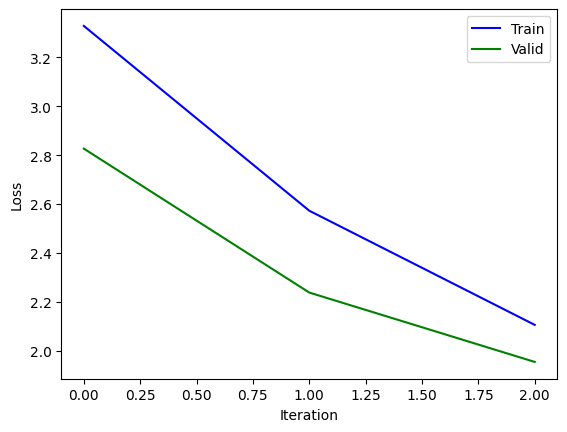

In [ ]:
plot_losses(metrics)

# Part III: Generate text

We can use the trained language model to generate novel text that is written in the style of the text it was trained on. At each timestep, the network outputs a probability distribution over tokens.  We can either take the token with maximum probability, or we can sample from this distribution.

TODO: Write the `greedy_strategy` and `generate_text_from` functions below:

In [ ]:
def greedy_strategy(probabilities: torch.FloatTensor) -> int:
    """
    Given a Tensor with probabilities, this function returns the token
    index with maximum probability
    :params probabilities: Tensor of size vocabulary_size
    """
    #TODO
    return torch.argmax(probabilities).item()

def sample_strategy(probabilities: torch.FloatTensor) -> int:
    """
    Given a Tensor with probabilities (categorical distribution), this function
    returns the character index of a sampled element
    :params probabilities: Tensor of size vocabulary_size
    """
    #TODO
    return torch.multinomial(probabilities, 1).item()

In [ ]:
from typing import Callable
class TextGenerator:
    def __init__(self, model, vocab):
        self.vocab = vocab
        self.model = model
        self.softmax = nn.Softmax(dim=-1)

    def generate_text_from(self, starting_text: str,
                           timesteps: int,
                           strategy: Callable[..., int],
                           temperature: float = 1.0):
        """
        This method generates text from based on the input text.
        :param starting_text: text that we condition on
        :param timesteps: how many tokens to generate
        :param strategy: either greedy_strategy or sample_strategy
        :param temperature: coefficient that scales outputs before turning them
        to probabilities. A low temperature (0.1) results in more conservative
        predictions, while a higher temperature (0.9) results in more diverse
        predictions
        """
        # convert text string to Tensor of token ids
        # string_len
        starting_data = text_to_tensor(starting_text, self.vocab).to(device)

        # 1 x string_len
        starting_data = starting_data.unsqueeze(0)

        # we first need to feed the starting text into the model
        # 1 x seq_len x d_model
        with torch.no_grad():
          all_prev_logits = self.model(starting_data)

        # logits for the last position in the sequence
        logits = all_prev_logits[:, -1, :]

        # scale by temperature
        # 1 x vocab_size
        logits = logits / temperature

        # vocab_size
        prev_probs = self.softmax(logits.squeeze())

        # start generating text
        generated_text = ""
        prev_tokens_list = [x for x in starting_data[0]]
        with torch.no_grad(): #no gradients computed inside this context
            for t in range(timesteps):
                #TODO: apply strategy to get current token prediction
                #top_token_idx = ...
                top_token_idx = strategy(prev_probs)


                # store already generated tokens
                prev_tokens_list.append(top_token_idx)

                # add character to already generated text
                generated_text += self.vocab.idx_to_token[top_token_idx]

                # generate token by token,
                # starting from the tokens we already generated
                current_input = torch.LongTensor(prev_tokens_list).to(device)
                current_input = current_input.unsqueeze(0)
                #TODO
                #all_prev_logits = ...
                all_prev_logits = self.model(current_input)
                prev_logits = all_prev_logits[:, -1, :]
                prev_probs = self.softmax(prev_logits.squeeze())

        return generated_text

In [ ]:
#CHECKPOINT: try greedy and sampling strategies (with different temperatures)
#and inspect the difference in outputs
#it's ok if they don't make complete sense, we undertrained :)
model.eval()
generator = TextGenerator(model, vocab)
starting_text = "Once upon a time "

print('-----Sampling from TransformerLM-----')
greedy_text = generator.generate_text_from(
            starting_text = starting_text,
            timesteps = 200,
            strategy = greedy_strategy,
            temperature = 1.0)

low_temp_text = generator.generate_text_from(
            starting_text = starting_text,
            timesteps = 200,
            strategy = sample_strategy,
            temperature = 0.5)
print("Greedy text: ", greedy_text)
print('*' * 10)
print("Low temperature text: ", low_temp_text)

-----Sampling from TransformerLM-----
Greedy text:  there was a little girl named Lily. She loved to play with her toys and play with her friends. One day, she saw a big tree in the park. She was very happy and said, "I want to play with you?" 

Lily said, "I want to play with you to play with me with you to play with me?" 

Lily said, "I want to play with you to play with you to play with me with you to be careful to play with the toys." 

Lily was happy and 
**********
Low temperature text:  there was a little girl named Lily. She was an old boy named Tom and loved to play together with a walk with his bath. two one day, her mom took the zipper the table at Jordan than the kids. Finally, Benny was sad.

Tom nodded and started to make a big tower in the listening in the map every day. The It was so excited. After they heard a tiny flute, It was a skirt she looked to OK, but it smiled and felt happy he had finally marketplace. After saying, he heard
